2D Manifold Visualizations
---

This notebook visualizes results generated by the script: scripts/lobpcg_modes_2d_opening_angle.py 
This notebook generates plots of the local minima / maxima and helps analysing the loss manifold.

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sci
import pynoisy
import xarray as xr
from tqdm.notebook import tqdm
import warnings
import glob, os
import ehtim as eh
from pynoisy import eht_functions as ehtf

In [88]:
"""
Function definitions
"""  
def compute_residual(files, measurements, degree):
    visibilities = measurements.data['vis']
    residuals = []
    for file in tqdm(files, leave=False):
        eigenvectors = pynoisy.utils.read_complex(file)
        residual = []
        for temporal_angle in eigenvectors.temporal_angle:
            A = eigenvectors.vis.sel(deg=range(degree), temporal_angle=temporal_angle).data.squeeze()
            projection = pynoisy.utils.least_squares_projection(visibilities, A)
            residual.append(np.mean(np.abs(visibilities - projection)**2))
        residual = xr.DataArray(residual, coords=[eigenvectors.temporal_angle]).expand_dims(spatial_angle=eigenvectors.spatial_angle)
        residuals.append(residual)
    residuals = xr.concat(residuals, dim='spatial_angle').sortby('spatial_angle').expand_dims(deg=[degree])
    
    return residuals

def visualization_2d(residuals, ax, degree=None, contours=False):
    dataset = residuals.sel(deg=degree) if degree else residuals
    minimum = dataset[dataset.argmin(dim=['temporal_angle', 'spatial_angle'])].coords
    dataset.plot(ax=ax, add_labels=False)
    ax.scatter(minimum['temporal_angle'], minimum['spatial_angle'], s=100, c='r', marker='o', label='Global minima')
    if hasattr(residuals, 'true_temporal_angle'):
        ax.scatter(residuals.true_temporal_angle, residuals.true_spatial_angle, s=100, c='w', marker='^', label='True')
    if contours:
        cs = dataset.plot.contour(ax=ax, cmap='RdBu_r')
        ax.clabel(cs, inline=1, fontsize=10)
    ax.set_title('Residual Loss (degree={})'.format(dataset.deg.data),fontsize=16)
    ax.set_xlabel('Temporal angle [rad]', fontsize=12)
    ax.set_ylabel('Spatial angle [rad]', fontsize=12)
    ax.legend(facecolor='white', framealpha=0.4)
    
def generate_grf_from_residuals(residuals, nx=128, ny=128, nt=64, seed=None):
    estimated_angles = residuals[residuals.argmin(dim=['temporal_angle', 'spatial_angle'])]
    advection = pynoisy.advection.general_xy(nx, ny, opening_angle=float(estimated_angles['temporal_angle']))
    diffusion = pynoisy.diffusion.general_xy(nx, ny, opening_angle=float(estimated_angles['spatial_angle']))
    solver = pynoisy.forward.HGRFSolver(nx, ny, advection, diffusion, seed=seed)
    grf = solver.run(num_frames=nt, n_jobs=4, verbose=False)
    grf.attrs.update(
        spatial_angle=float(estimated_angles['spatial_angle']),
        temporal_angle=float(estimated_angles['temporal_angle'])
    )
    grf.name = None
    return grf

In [3]:
"""
Load precomputed modes (generated by the script: scripts/lobpcg_modes_2d_opening_angle.py)
"""
directory = '../../opening_angles_modes/'
files = [file for file in glob.glob(os.path.join(directory, '*.nc')) \
         if file.split('/')[-1].startswith('vismodes.flipped.2019array')]
eigenvector = pynoisy.utils.read_complex(files[0])

### Generate Measurements 

In [34]:
uvfits_path = '/home/aviad/Code/eht-imaging/SgrA/data/ER6_may2020/hops/hops_3601_SGRA_lo_V0_both_scan_netcal_LMTcal_normalized_10s.uvfits'
array_path = '/home/aviad/Code/eht-imaging/arrays/EHT2019.txt'
obs_sgra = ehtf.load_obs(array_path, uvfits_path)

Loading uvfits:  /home/aviad/Code/eht-imaging/SgrA/data/ER6_may2020/hops/hops_3601_SGRA_lo_V0_both_scan_netcal_LMTcal_normalized_10s.uvfits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
No NX table in uvfits!


/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/ehtim-1.2-py3.7.egg/ehtim/io/load.py:1372: RuntimeWarning: Mean of empty slice
  rr = np.nanmean(np.nanmean(rr_2d, axis=2), axis=1)[mask]
/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/ehtim-1.2-py3.7.egg/ehtim/io/load.py:1374: RuntimeWarning: Mean of empty slice
  rl = np.nanmean(np.nanmean(rl_2d, axis=2), axis=1)[mask]
/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/ehtim-1.2-py3.7.egg/ehtim/io/load.py:1375: RuntimeWarning: Mean of empty slice
  lr = np.nanmean(np.nanmean(lr_2d, axis=2), axis=1)[mask]
/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/ehtim-1.2-py3.7.egg/ehtim/obsdata.py:4628: ResourceWarning: unclosed file <_io.FileIO name='/home/aviad/Code/eht-imaging/SgrA/data/ER6_may2020/hops/hops_3601_SGRA_lo_V0_both_scan_netcal_LMTcal_normalized_10s.uvfits' mode='rb' closefd=True>
  remove_nan=remove_nan, allow_singlepol=allow_singlepol)


In [232]:
nt, nx, ny = 64, 64, 64
fov = 140.0

advection = pynoisy.advection.general_xy(nx, ny)
diffusion = pynoisy.diffusion.general_xy(nx, ny)
solver = pynoisy.forward.HGRFSolver(nx, ny, advection, diffusion, seed=27669)
grf = solver.run(num_frames=nt, n_jobs=4, verbose=False)

# Flux normalization
grf = grf / np.abs(grf).sum(['x', 'y']).mean('t')

# Generate observations
movie = ehtf.xarray_to_hdf5(grf, obs_sgra, fov=fov)
measurements = movie.observe_same_nonoise(obs_sgra)

Setting solver seed to: 27669
Merging 64 frames from MJD 57854 9.00 hr to MJD 57854 15.02 hr
Producing clean visibilities from movie with nfft FT . . . 


<IPython.core.display.Javascript object>


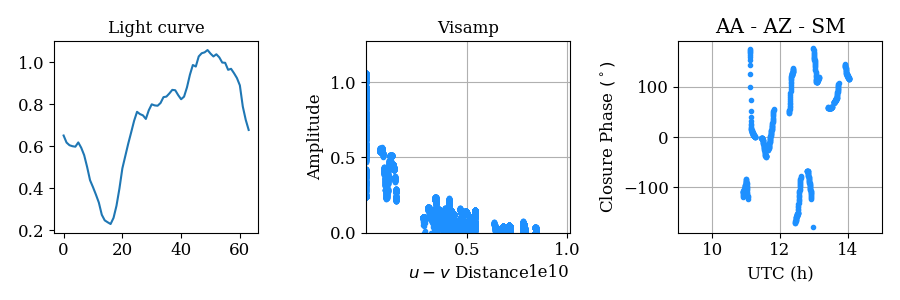

/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/ehtim-1.2-py3.7.egg/ehtim/obsdata.py:2797: ComplexWarning: Casting complex values to real discards the imaginary part
  cps.append(bi.astype(np.dtype(ehc.DTCPHASE)))


In [233]:
%matplotlib notebook

fig, ax = plt.subplots(1, 3, figsize=(9,3))
ax[0].plot(movie.lightcurve)
ax[0].set_title('Light curve', fontsize=12);

measurements.plotall('uvdist','amp', axis=ax[1], ebar=False);
ax[1].set_title('Visamp', fontsize=12);

measurements.plot_cphase('AA','AZ', 'SM', axis=ax[2], ebar=False);

plt.tight_layout()

### Compute Residuals
---
Compute residuals using LOBPCG projection residual from precomputed modes and save as a NetCDF dataset

In [79]:
degrees = [4, 8, 16, 24]
residuals = xr.concat([compute_residual(files, measurements, deg) for deg in degrees], dim='deg')

# update attributes
residuals.attrs = eigenvector.attrs
residuals.attrs.update(
    file_num=len(files),
    true_temporal_angle=solver.advection.opening_angle,
    true_spatial_angle=solver.diffusion.opening_angle,
    directory=directory, 
    measurement_seed=solver.seed,
    flipy='True (due to eht y-axis flipping)'
)

# Save output NetCDF
residuals.to_netcdf(
    os.path.join(directory, 'visibility.residuals.spatial_angle{:1.3}_temporal_angle{:1.3}_{}x{}_seed{}.nc'.format(
        residuals.true_spatial_angle, residuals.true_temporal_angle, 
        residuals.spatial_angle.size, residuals.temporal_angle.size, solver.seed)))

### Compute statistics

In [90]:
num_grid = 4
degree = 24

#num_seeds = 10
#seed_grid = [np.random.randint(0, 32767) for i in range(num_seeds)]

seed_grid = [27669]
true_spatial_angle = np.linspace(-np.pi/2, np.pi/2, num_grid)
true_temporal_angle = np.linspace(-np.pi, np.pi, num_grid)

advection = pynoisy.advection.general_xy(nx, ny)
diffusion = pynoisy.diffusion.general_xy(nx, ny)
solver = pynoisy.forward.HGRFSolver(nx, ny, advection, diffusion)

residual_stats = []
for seed in tqdm(seed_grid, desc='seed'):
    residual_dataset = []
    for spatial_angle in true_spatial_angle:
        solver.diffusion.update(pynoisy.diffusion.general_xy(nx, ny, opening_angle=spatial_angle))
        residuals = []
        for temporal_angle in true_temporal_angle:
            solver.advection.update(pynoisy.advection.general_xy(nx, ny, opening_angle=temporal_angle))
            grf = solver.run(num_frames=nt, n_jobs=4, verbose=False, seed=seed)
            
            # Flux normalization
            grf = grf / np.abs(grf).sum(['x', 'y'])

            # Generate observations
            movie = ehtf.xarray_to_hdf5(grf, obs_sgra, fov=fov)
            measurements = movie.observe_same_nonoise(obs_sgra)

            output = compute_residual(files, measurements, degree)
            residuals.append(output.expand_dims({
                'seed': [seed],
                'true_temporal_angle': [temporal_angle],
                'true_spatial_angle': [spatial_angle]
            }))
        residual_dataset.append(xr.concat(residuals, dim='true_temporal_angle'))
    residual_stats.append(xr.concat(residual_dataset, dim='true_spatial_angle'))
residual_stats = xr.concat(residual_stats, dim='seed').squeeze()

# update attributes
residual_stats.attrs = eigenvector.attrs
residual_stats.attrs.update(
    file_num=len(files),
    directory=directory)

# Save output NetCDF
residual_stats.to_netcdf(
    os.path.join(directory, 'visibility.residuals.stats.num_spatial{}.num_temporal{}.num_seed{}.{}x{}_meanxy.nc'.format(
        residual_stats.true_spatial_angle.size, residual_stats.true_temporal_angle.size, 
        residual_stats.seed.size, residual_stats.spatial_angle.size, residual_stats.temporal_angle.size)))


Merging 128 frames from MJD 57854 9.00 hr to MJD 57854 15.02 hr
Producing clean visibilities from movie with nfft FT . . . 



Merging 128 frames from MJD 57854 9.00 hr to MJD 57854 15.02 hr
Producing clean visibilities from movie with nfft FT . . . 



Merging 128 frames from MJD 57854 9.00 hr to MJD 57854 15.02 hr
Producing clean visibilities from movie with nfft FT . . . 



Merging 128 frames from MJD 57854 9.00 hr to MJD 57854 15.02 hr
Producing clean visibilities from movie with nfft FT . . . 



Merging 128 frames from MJD 57854 9.00 hr to MJD 57854 15.02 hr
Producing clean visibilities from movie with nfft FT . . . 



Merging 128 frames from MJD 57854 9.00 hr to MJD 57854 15.02 hr
Producing clean visibilities from movie with nfft FT . . . 



Merging 128 frames from MJD 57854 9.00 hr to MJD 57854 15.02 hr
Producing clean visibilities from movie with nfft FT . . . 



Merging 128 frames from MJD 57854 9.00 hr to MJD 57854 15.02 hr
Producing clean visibilities from movie with nfft FT . . . 



Merging 128 frames from MJD 57854 9.00 hr to MJD 57854 15.02 hr
Producing clean visibilities from movie with nfft FT . . . 



Merging 128 frames from MJD 57854 9.00 hr to MJD 57854 15.02 hr
Producing clean visibilities from movie with nfft FT . . . 



Merging 128 frames from MJD 57854 9.00 hr to MJD 57854 15.02 hr
Producing clean visibilities from movie with nfft FT . . . 



Merging 128 frames from MJD 57854 9.00 hr to MJD 57854 15.02 hr
Producing clean visibilities from movie with nfft FT . . . 



Merging 128 frames from MJD 57854 9.00 hr to MJD 57854 15.02 hr
Producing clean visibilities from movie with nfft FT . . . 



Merging 128 frames from MJD 57854 9.00 hr to MJD 57854 15.02 hr
Producing clean visibilities from movie with nfft FT . . . 



Merging 128 frames from MJD 57854 9.00 hr to MJD 57854 15.02 hr
Producing clean visibilities from movie with nfft FT . . . 



Merging 128 frames from MJD 57854 9.00 hr to MJD 57854 15.02 hr
Producing clean visibilities from movie with nfft FT . . . 


### Load & Visualize Residuals
---

Load and visualize precomputed residuals

<IPython.core.display.Javascript object>


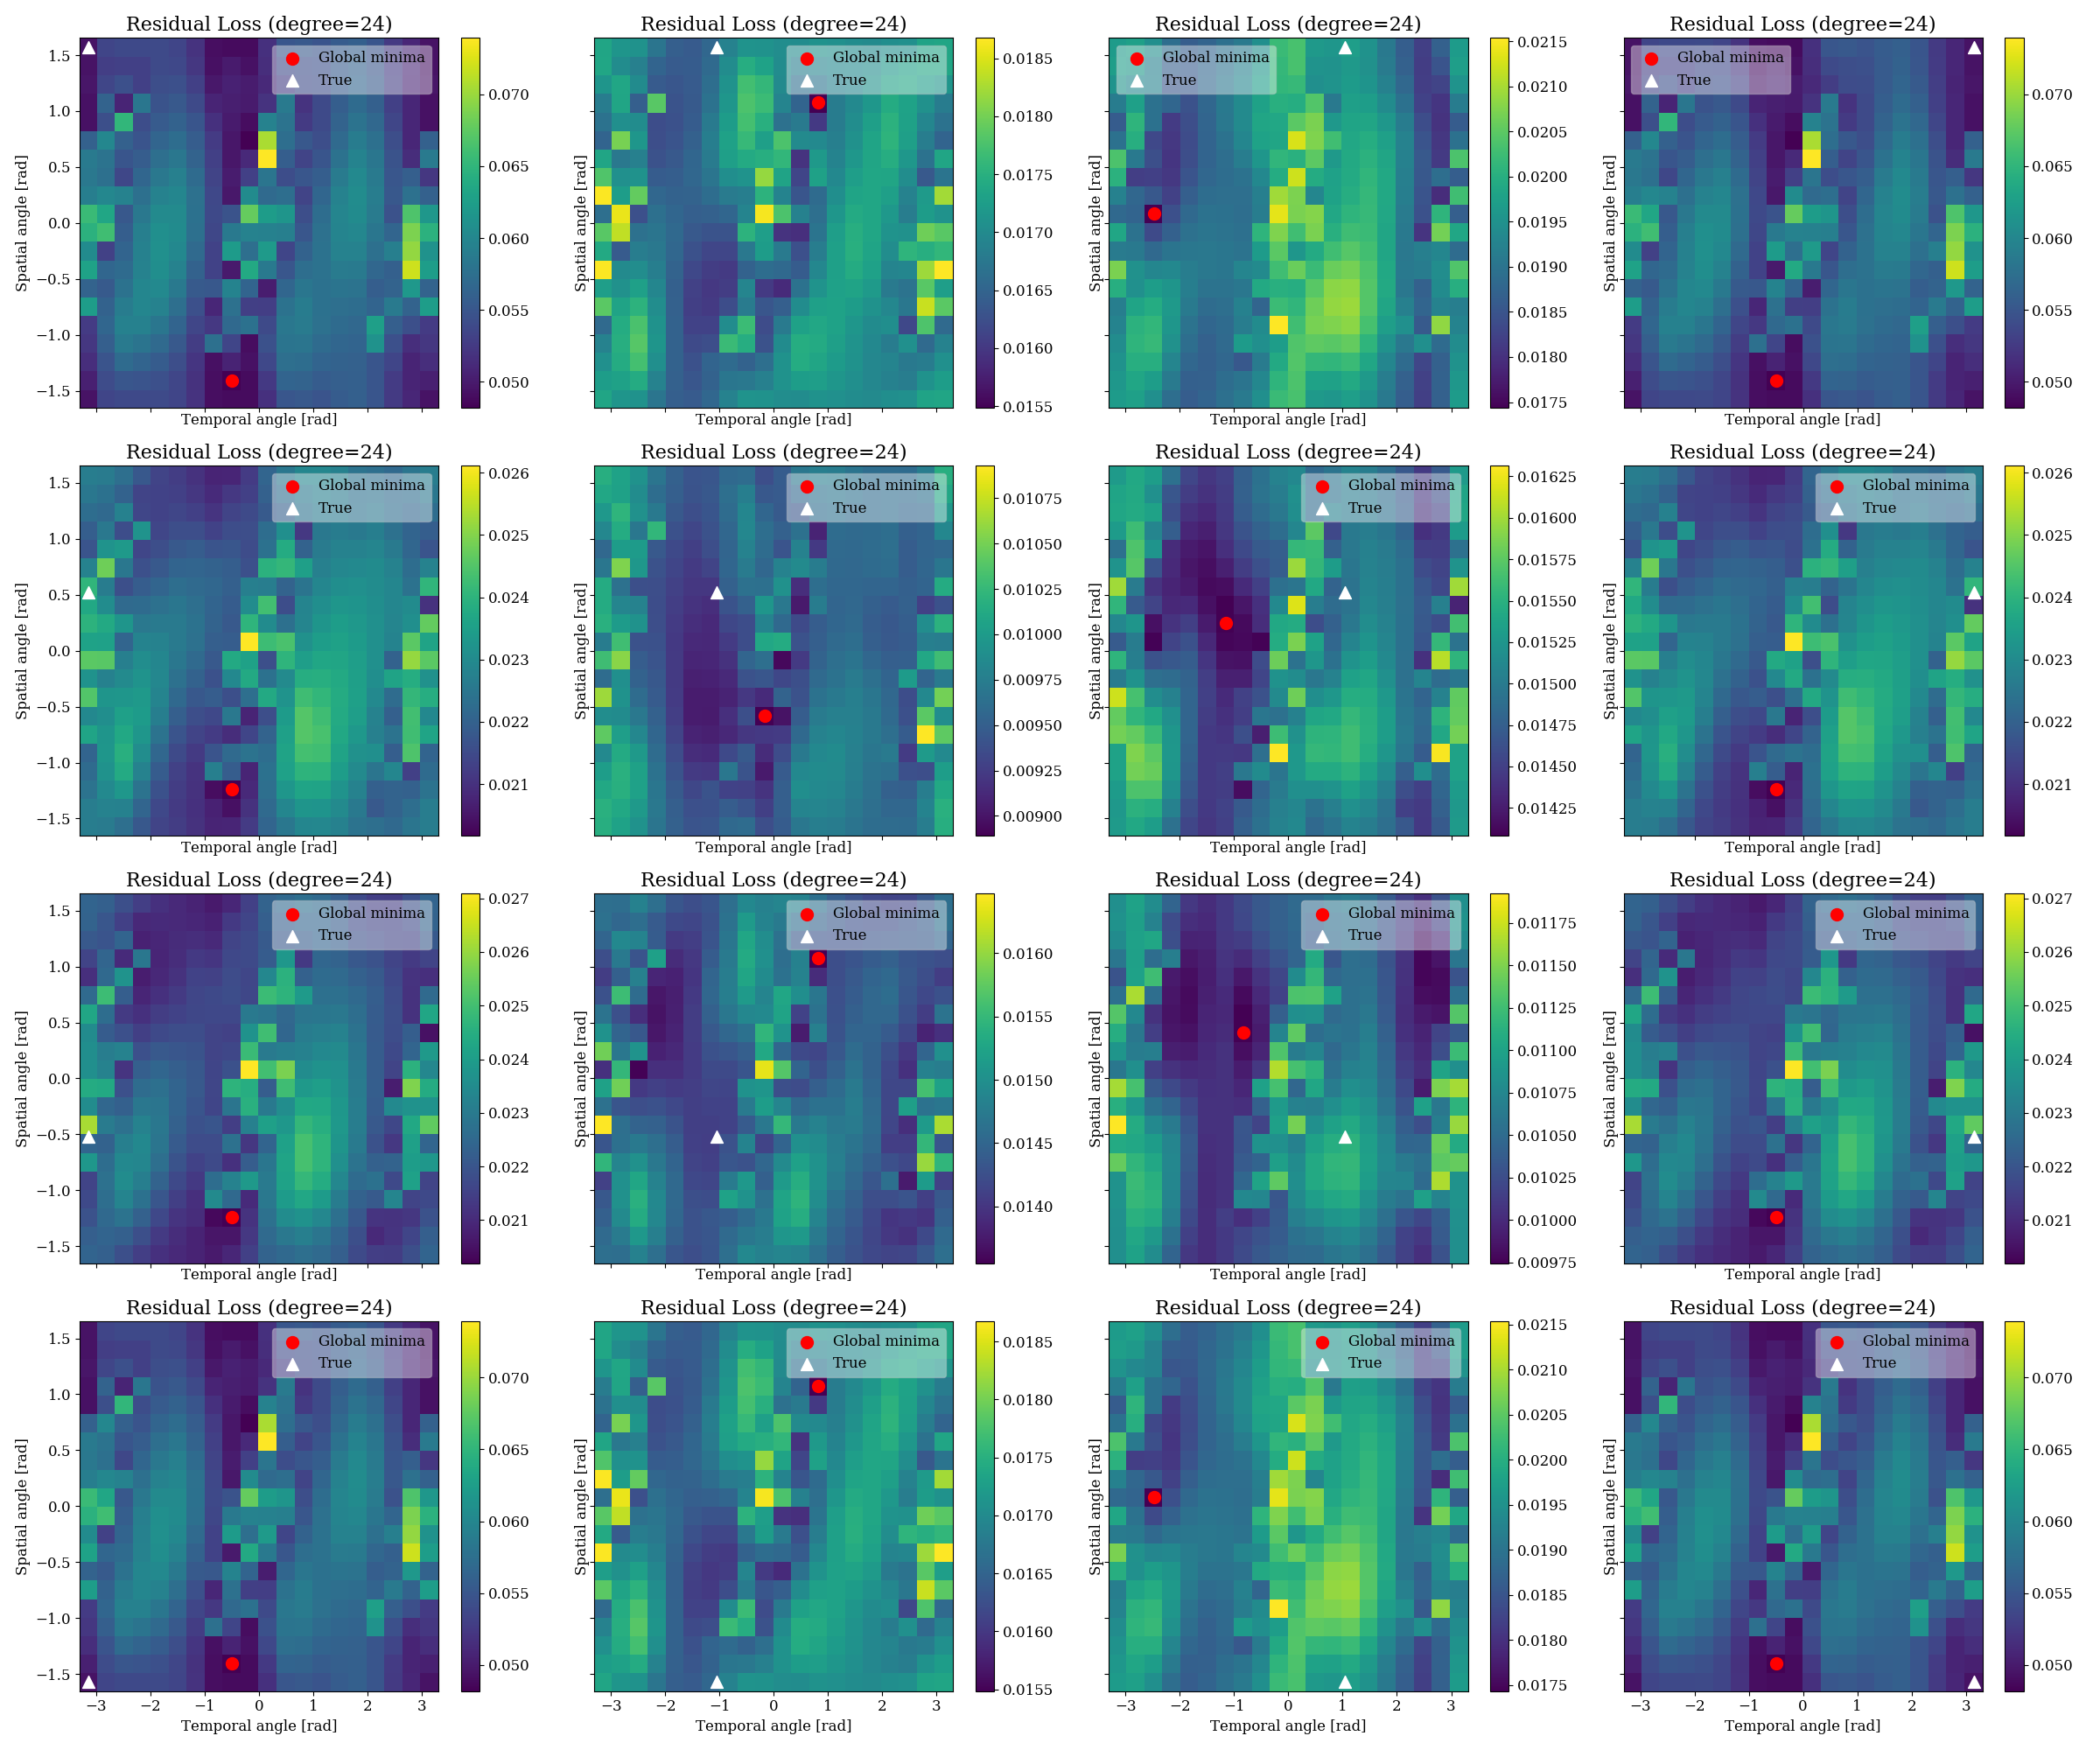

In [89]:
load_path = '../../opening_angles_modes/visibility.residuals.stats.num_spatial4.num_temporal4.num_seed1.20x20.nc'
residuals = xr.load_dataarray(load_path)

num_rows = residuals.true_temporal_angle.size
num_cols = residuals.true_spatial_angle.size
fig, ax = plt.subplots(num_rows, num_cols, figsize=(24,20), sharey=True, sharex=True)
for row in range(num_rows):
    for col in range(num_cols):
        visualization_2d(residuals.isel(true_temporal_angle=row, true_spatial_angle=col), 
                         ax=ax[num_cols-col-1, row])
plt.tight_layout()

<IPython.core.display.Javascript object>


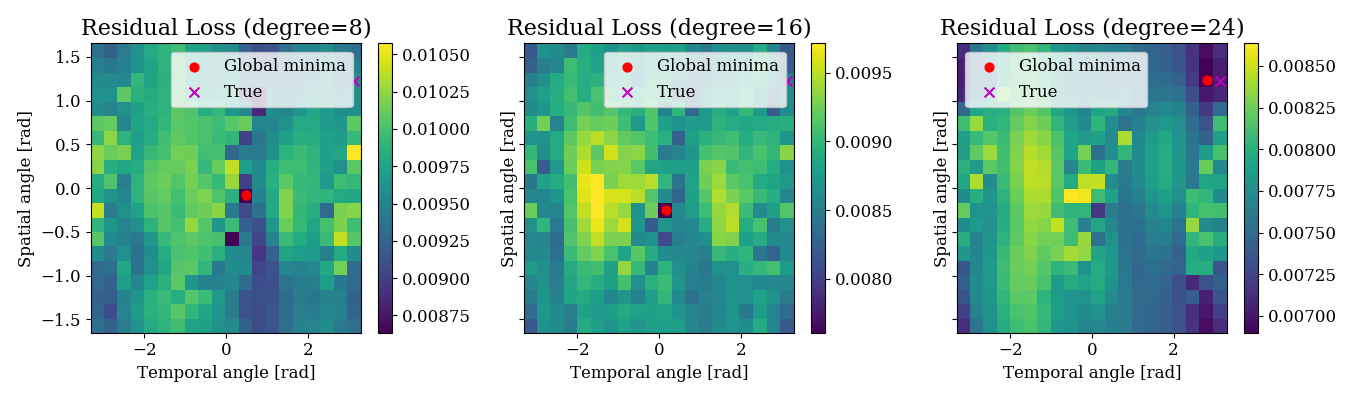

In [77]:
load_path = '../../opening_angles_modes/visibility.residuals.spatial_angle1.22_temporal_angle3.14_20x20_seed27669.nc'

residuals = xr.load_dataarray(load_path)

%matplotlib notebook
fig, ax = plt.subplots(1, 3, figsize=(13.5,4), sharey=True)
visualization_2d(residuals, degree=8, ax=ax[0])
visualization_2d(residuals, degree=16, ax=ax[1])
visualization_2d(residuals, degree=24, ax=ax[2])
plt.tight_layout()

<IPython.core.display.Javascript object>


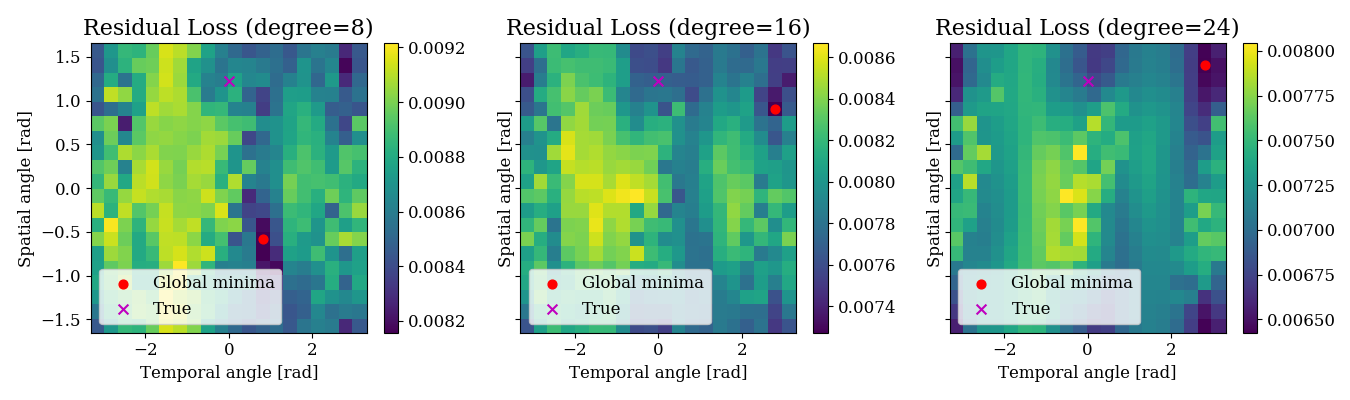

In [80]:
load_path = '../../opening_angles_modes/visibility.residuals.spatial_angle1.22_temporal_angle0.0_20x20_seed27669.nc'

residuals = xr.load_dataarray(load_path)

%matplotlib notebook
fig, ax = plt.subplots(1, 3, figsize=(13.5,4), sharey=True)
visualization_2d(residuals, degree=8, ax=ax[0])
visualization_2d(residuals, degree=16, ax=ax[1])
visualization_2d(residuals, degree=24, ax=ax[2])
plt.tight_layout()

<IPython.core.display.Javascript object>


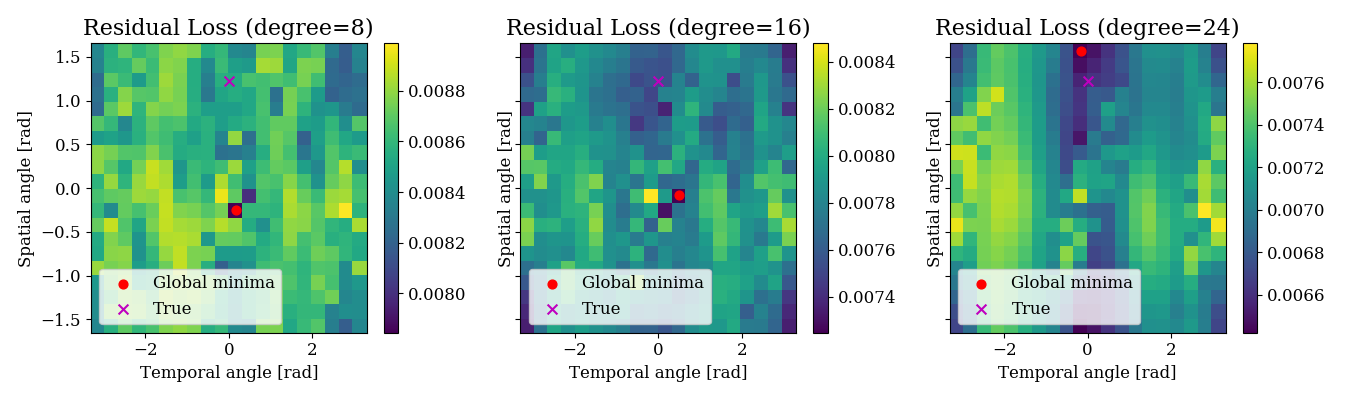

In [83]:
%matplotlib notebook
fig, ax = plt.subplots(1, 3, figsize=(13.5,4), sharey=True)
visualization_2d(residuals, degree=8, ax=ax[0])
visualization_2d(residuals, degree=16, ax=ax[1])
visualization_2d(residuals, degree=24, ax=ax[2])
plt.tight_layout()